In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Define image transformations for training and testing
train_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
# Directories for datasets
train_dir = "data_smiles/Training_Group"
augmented_train_dir = "data_smiles/Training_Group_Augmented"
test_dir = "data_smiles/Testing_Group"

# Combine the two training folders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
augmented_train_dataset = datasets.ImageFolder(
    root=augmented_train_dir, transform=train_transforms
)

# Combine both datasets using torch.utils.data.ConcatDataset
combined_train_dataset = torch.utils.data.ConcatDataset(
    [train_dataset, augmented_train_dataset]
)

# combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset])

# Load the datasets into DataLoader
train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(
    datasets.ImageFolder(root=test_dir, transform=test_transforms),
    batch_size=64,
    shuffle=False,
)

# Training ResNet18 combine pretrained weights

In [4]:
# Load a pretrained ResNet18 model
model = models.resnet18(weights=True)

# Modify the fully connected layer to output 2 classes (binary classification)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


```bash
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\predator/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:09<00:00, 5.12MB/s]
```

# Training ResNet18 from scratch

In [5]:
# Training ResNet18 combine pretrained weights
model = models.resnet18(weights=False)

# Modify the fully connected layer to output 2 classes (binary classification)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training ResNet18 transfer learning

In [4]:
# Load a pretrained model (e.g., ResNet18 for binary classification)
model = models.resnet18(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (2 classes)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer (only updating the final layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)  # Only optimize the final layer


c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Simple train

In [27]:
# Function to train the model
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

## Simple train with plot train loss

In [ ]:
# Function to train the model and return results for plotting
def train_model_with_loss_plot(
    model, train_loader, criterion, optimizer, num_epochs=25
):
    # Lists to store loss and accuracy over time
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Append to history
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)

        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Return the loss and accuracy history
    return loss_history, accuracy_history


# Plot function to visualize loss over time
def plot_loss(loss_history):
    plt.figure()
    plt.plot(range(len(loss_history)), loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.show()

## Train with plot train, test loss

In [10]:
# Function to train the model, evaluate on test_loader, and include early stopping
def train_model_with_early_stopping(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=25, patience=10
):
    # Lists to store loss and accuracy over time
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    # Early stopping variables
    best_loss = np.inf
    epochs_without_improvement = 0
    best_model_state = None
    save_dir = "models"

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics for training
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate loss and accuracy for the epoch (training)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total

        train_loss_history.append(epoch_train_loss)
        train_accuracy_history.append(epoch_train_acc)

        # Evaluate the model on the test set after each epoch
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = correct_test / total_test

        test_loss_history.append(epoch_test_loss)
        test_accuracy_history.append(epoch_test_acc)

        # print train accuracy and test accuracy
        print(
            f"Train Accuracy: {epoch_train_acc:.4f}, Test Accuracy: {epoch_test_acc:.4f}"
        )

        # Early stopping logic
        if epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0  # Reset counter if improvement

            # Save the best model
            torch.save(best_model_state, os.path.join(save_dir, "best_model.pth"))
            print(f"Best model saved at epoch {epoch}")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs due to no improvement.")
            break

    # Restore the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Return loss and accuracy history for training and testing
    return (
        train_loss_history,
        train_accuracy_history,
        test_loss_history,
        test_accuracy_history,
    )

## Evaluate and plot performance

In [5]:
# Function to evaluate the model
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {correct / total:.4f}")

In [6]:
# Function to evaluate the model with AUC metric
def evaluate_model_auc(model, test_loader, device):
    model.eval()
    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits or probabilities)
            outputs = model(inputs)

            # Apply softmax to get probabilities if your model returns logits
            probabilities = (
                F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            )  # Assuming binary classification

            # Collect true labels and predicted probabilities
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(probabilities)

    # Compute AUC
    auc_score = roc_auc_score(true_labels, pred_probs)
    print(f"Test AUC: {auc_score:.4f}")

In [7]:
# Function to evaluate the model and plot ROC curve
def evaluate_model_and_plot_auc(model, test_loader, device):
    model.eval()
    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits or probabilities)
            outputs = model(inputs)

            # Apply softmax to get probabilities if your model returns logits
            probabilities = (
                F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            )  # Assuming binary classification

            # Collect true labels and predicted probabilities
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(probabilities)

    # Compute AUC
    auc_score = roc_auc_score(true_labels, pred_probs)
    print(f"Test AUC: {auc_score:.4f}")

    # Compute FPR and TPR for plotting ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# Plot function to visualize loss over time
def plot_loss(train_loss_history, test_loss_history):
    plt.figure()
    plt.plot(range(len(train_loss_history)), train_loss_history, label="Training Loss")
    plt.plot(range(len(test_loss_history)), test_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Time")
    plt.legend()
    plt.show()


# Plot function to visualize test accuracy over time
def plot_accuracy(train_accuracy_history, test_accuracy_history):
    plt.figure()
    plt.plot(
        range(len(train_accuracy_history)),
        train_accuracy_history,
        label="Training Accuracy",
    )
    plt.plot(
        range(len(test_accuracy_history)),
        test_accuracy_history,
        label="Validation Accuracy",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy Over Time")
    plt.legend()
    plt.show()

## Start training

In [ ]:
%%time
# Train the model
train_model(model, criterion, optimizer, num_epochs=1)

In [ ]:
%%time
# train models
loss_history, accuracy_history = train_model_with_loss_plot(
    model, train_loader, criterion, optimizer, num_epochs=100
)

# Plot the loss over time
plot_loss(loss_history)

In [34]:
# Evaluate the model on the testing data
evaluate_model(model)

Test Accuracy: 0.6888


In [35]:
evaluate_model_auc(model, test_loader, device)

Test AUC: 0.7622


Test AUC: 0.7622


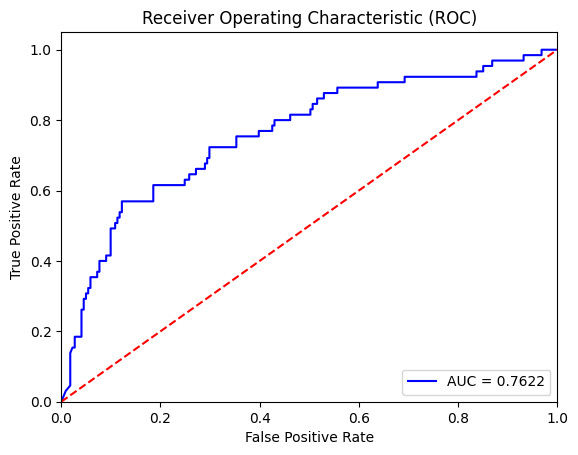

In [36]:
evaluate_model_and_plot_auc(model, test_loader, device)

Test AUC: 1.0000


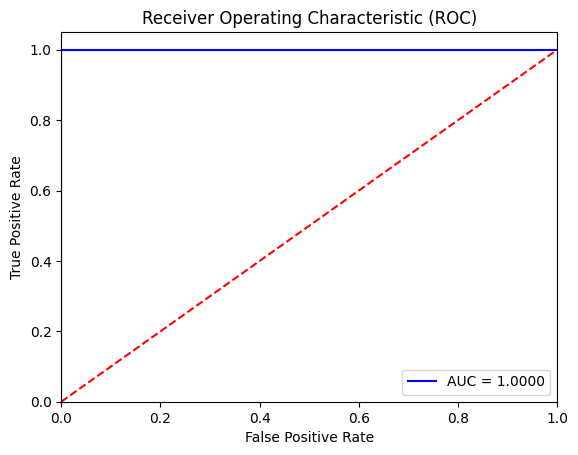

In [37]:
evaluate_model_and_plot_auc(model, train_loader, device)

## Training and testing each epoch (no augmentation)

In [9]:
%%time
# Train the model with early stopping
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = (
    train_model_with_early_stopping(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=25,
        patience=10,
    )
)

Epoch 0/24
Train Accuracy: 0.5359, Test Accuracy: 0.7448
Epoch 1/24
Train Accuracy: 0.6172, Test Accuracy: 0.5629
Epoch 2/24
Train Accuracy: 0.6551, Test Accuracy: 0.7098
Epoch 3/24
Train Accuracy: 0.7099, Test Accuracy: 0.4476
Epoch 4/24
Train Accuracy: 0.7631, Test Accuracy: 0.7832
Epoch 5/24
Train Accuracy: 0.7808, Test Accuracy: 0.2972
Epoch 6/24
Train Accuracy: 0.8437, Test Accuracy: 0.4545
Epoch 7/24
Train Accuracy: 0.8654, Test Accuracy: 0.5210
Epoch 8/24
Train Accuracy: 0.9186, Test Accuracy: 0.5350
Epoch 9/24
Train Accuracy: 0.9138, Test Accuracy: 0.6748
Epoch 10/24
Train Accuracy: 0.9420, Test Accuracy: 0.3007
Early stopping after 11 epochs due to no improvement.
CPU times: total: 4min 42s
Wall time: 57 s


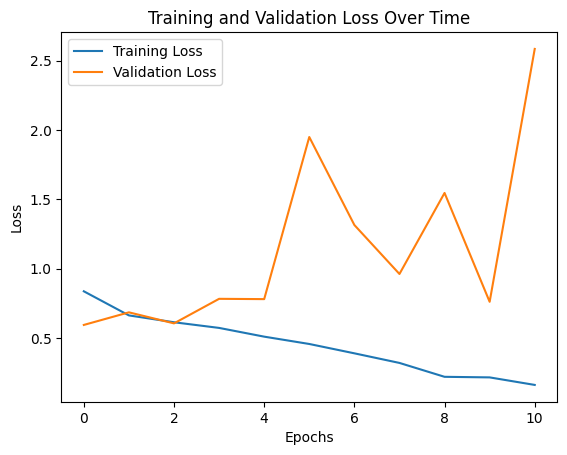

In [10]:
plot_loss(train_loss_history, test_loss_history)

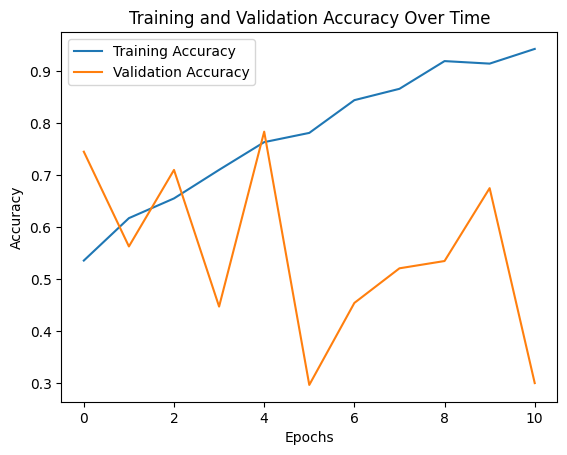

In [11]:
plot_accuracy(train_accuracy_history, test_accuracy_history)

## Training and testing each epoch (augmentation)

In [11]:
%%time
# Train the model with early stopping
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = (
    train_model_with_early_stopping(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=80,
        patience=80,
    )
)

Epoch 0/79
Train Accuracy: 0.5763, Test Accuracy: 0.5140
Best model saved at epoch 0
Epoch 1/79
Train Accuracy: 0.6289, Test Accuracy: 0.7413
Best model saved at epoch 1
Epoch 2/79
Train Accuracy: 0.6292, Test Accuracy: 0.7552
Best model saved at epoch 2
Epoch 3/79
Train Accuracy: 0.6558, Test Accuracy: 0.6993
Epoch 4/79
Train Accuracy: 0.6483, Test Accuracy: 0.3636
Epoch 5/79
Train Accuracy: 0.6429, Test Accuracy: 0.7727
Epoch 6/79
Train Accuracy: 0.6501, Test Accuracy: 0.7203
Epoch 7/79
Train Accuracy: 0.6604, Test Accuracy: 0.5559
Epoch 8/79
Train Accuracy: 0.6644, Test Accuracy: 0.7517
Epoch 9/79
Train Accuracy: 0.6557, Test Accuracy: 0.7343
Epoch 10/79
Train Accuracy: 0.6685, Test Accuracy: 0.5035
Epoch 11/79
Train Accuracy: 0.6659, Test Accuracy: 0.3566
Epoch 12/79
Train Accuracy: 0.6672, Test Accuracy: 0.6259
Epoch 13/79
Train Accuracy: 0.6555, Test Accuracy: 0.6084
Epoch 14/79
Train Accuracy: 0.6558, Test Accuracy: 0.7168
Epoch 15/79
Train Accuracy: 0.6508, Test Accuracy: 0.559

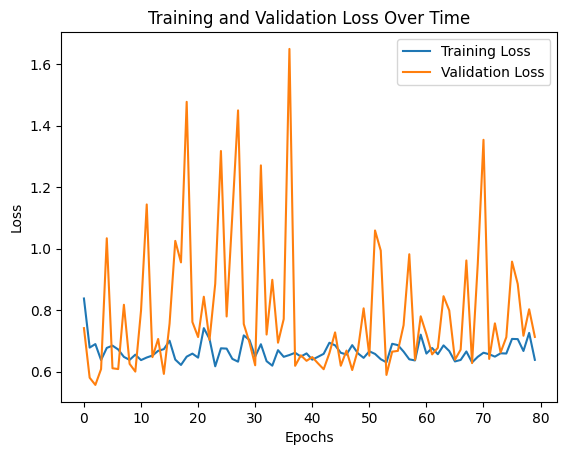

In [12]:
plot_loss(train_loss_history, test_loss_history)

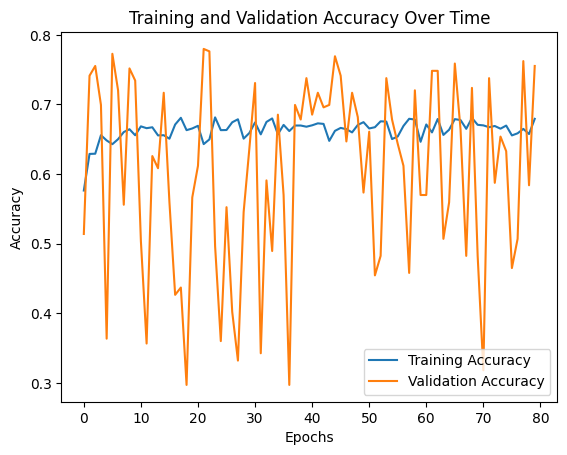

In [13]:
plot_accuracy(train_accuracy_history, test_accuracy_history)

Test AUC: 0.6385


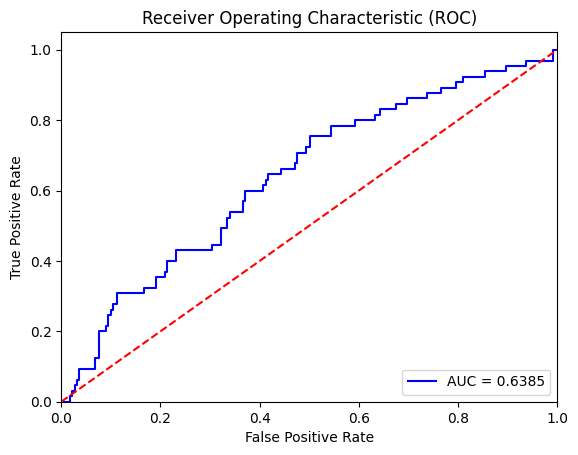

In [14]:
evaluate_model_and_plot_auc(model, test_loader, device)